In [1]:
library(tidyverse)
library(ggplot2)
deposit <- read_csv("_build/data/marketing.csv")

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang


Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2


-- Attaching packages --------------------------------------- tidyverse 1.2.1 --


v ggplot2 3.1.1       v purrr   0.3.2  
v tibble  2.1.1       v dplyr   0.8.0.1
v tidyr   0.8.3       v stringr 1.4.0  
v readr   1.3.1       v forcats 0.4.0  


-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()


Parsed with column specification:
cols(
  age = col_double(),
  marital = col_character(),
  education = col_character(),
  default = col_character(),
  housing = col_character(),
  loan = col_character(),
  contact = col_character(),
  duration = col_double(),
  campaign = col_double(),
  previous = col_double(),
  poutcome = col_character(),
  subscription = col_double()
)


# Simple Logistic Regression

Instead of modeling the response variable ($Y$) directly, logistic regression uses independent ($X$) variables to model the probability that $Y$ equals the outcome of interest. In other words, logistic regression allows us to model $P(Y = 1 | X)$, or the probability that $Y$ equals one *given* $X$. To do this, we need a mathematical function that provides predictions between zero and one for all possible values of $X$. There are many functions that meet this description, but for logistic regression we use the **logistic function** and assume the following relationship:

$$P(Y = 1 | X) = \frac{e^{\beta_0+\beta_1X}}{1+e^{\beta_0+\beta_1X}}$$

As with linear regression, our goal is to find estimates of $\beta_0$ and $\beta_1$ using our observed data. Whereas linear regression does this using the method of least squares, logistic regression calculates sample estimates of $\beta_0$ and $\beta_1$ using a method known as **maximum likelihood estimation (MLE)**. We will not describe MLE in detail, but it essentially uses the sample data to find estimates of $\beta_0$ and $\beta_1$ such that the model's predicted probability is high when $Y$ actually equals one and low when $Y$ actually equals zero. 

We can fit a logistic regression model in R with the `glm()` command (the `glm` stands for **g**eneral **l**inear **m**odel). This function uses the following syntax:

```{admonition} Syntax
`glm(y ~ x, data = df, family = "binomial")`
+ *Required arguments*
  - `y`: The name of the dependent ($Y$) variable.
  - `x`: The name of the independent ($X$) variable.
  - `data`: The name of the data frame with the `y` and `x` variables.
  - `family`: The type of model we would like to fit; for logistic regression, we set this equal to `"binomial"` because we are modeling a binomial process (*i.e.*, one with two possible outcomes).
```

As with linear regression, we can fit a logistic regression to our data and then use `summary()` to obtain detailed information about the model:

In [2]:
depositLog <- glm(subscription ~ duration, data = deposit, family = "binomial")
summary(depositLog)


Call:
glm(formula = subscription ~ duration, family = "binomial", data = deposit)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.8683  -0.4303  -0.3548  -0.3106   2.5264  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -3.2559346  0.0845767  -38.50   <2e-16 ***
duration     0.0035496  0.0001714   20.71   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 3231.0  on 4520  degrees of freedom
Residual deviance: 2701.8  on 4519  degrees of freedom
AIC: 2705.8

Number of Fisher Scoring iterations: 5


Based on this output, our estimated regression equation is:

$$\begin{aligned}predicted \;probability = \hat{p}(y=1) = \frac{e^{-3.2559346 + 0.0035496(duration)}}{1+e^{-3.2559346 + 0.0035496(duration)}}\end{aligned}$$

If we plot this line on top of our data, we can see how logistic regression suits the problem better than linear regression. Because the logistic function is bounded between zero and one, we see the characteristic "s-shape" curve:

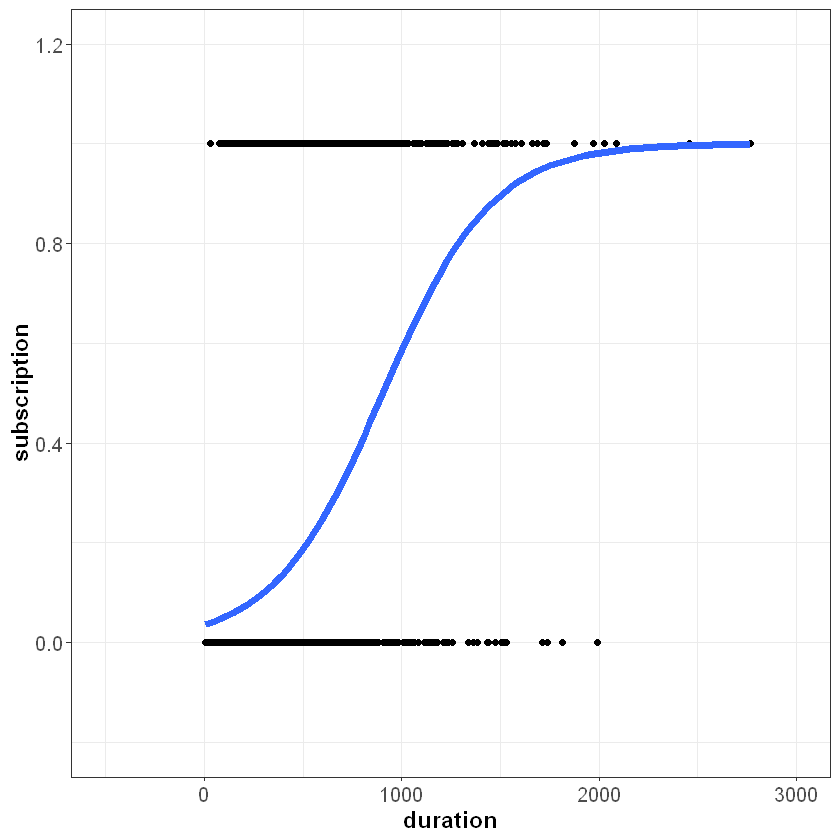

In [3]:
suppressWarnings(print(ggplot(deposit, aes(x=duration, y=subscription)) + geom_point()  +
  geom_smooth(method='glm', se=F, method.args = list(family=binomial), size=2) + theme_bw() +
  xlim(-500, 3000) + ylim(-0.2, 1.2) +
  theme(axis.text=element_text(size=12),
        axis.title=element_text(size=14,face="bold"))))

Now if `duration` equals 2,500 seconds, the model's prediction does not exceed one:

$$\begin{aligned}predicted \;probability = \hat{p}(y=1) & \approx \frac{e^{-3.2559346 + 0.0035496(2500)}}{1+e^{-3.2559346 + 0.0035496(2500)}} \\ & \approx \frac{275.3237478}{276.3237478} \\ & \approx 0.9963811\end{aligned}$$

We can also use the model to make predictions with the `predict()` function. Note that for logistic regression, we need to include `type="response"`. This ensures that `predict()` returns the prediction as a probability between zero and one (as opposed to the log-odds form).

In [4]:
newData <- data.frame(duration = 2500)
predict(depositLog, newData, type = "response")

1 
0.9963811

In [5]:
print(predict(depositLog, newData, type = "response"))

        1 
0.9963811 


Because the logistic regression models a non-linear relationship, we cannot interpret the model coefficients as we did with linear regression. Instead, we interpret the coefficient on a continuous $X$ as follows:

 - If $b_1>0$, a one unit increase in the predictor corresponds to an *increase* in the probability that $y = 1$. Note that we don't specify the amount of the increase, as this is not as straight forward as linear regression where the amount is the value of the coefficient.

 -  If $b_1<0$, a one unit increase in the predictor corresponds to a *decrease* in the probability that $y = 1$. Again, note that we don't specify the amount of the decrease.
 
Using this guideline, we can interpret the $b_1$ coefficient in our model as follows:

+ Because $b_1$ is *greater than* zero, a one-unit increase in `duration` corresponds to an *increase* in the probability that the contacted person makes a deposit.

Now instead of a continuous $X$ like `duration`, let's use the categorical $X$ variable, `loan`. As a reminder, `glm()` automatically converts categorical variables to dummy variables behind the scenes, so we can simply include `loan` in our call to `glm()`:

In [6]:
depositLogDummy <- glm(subscription ~ loan, data = deposit, family = "binomial")
summary(depositLogDummy)


Call:
glm(formula = subscription ~ loan, family = "binomial", data = deposit)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.5163  -0.5163  -0.5163  -0.3585   2.3567  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -1.94770    0.04889 -39.837  < 2e-16 ***
loanyes     -0.76499    0.16489  -4.639 3.49e-06 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 3231.0  on 4520  degrees of freedom
Residual deviance: 3205.2  on 4519  degrees of freedom
AIC: 3209.2

Number of Fisher Scoring iterations: 5


 
If $X$ is a dummy variable, we interpret the coefficient as follows:

 - If $b_1>0$, observations where the dummy equals one have a *greater* probability that $y = 1$.

 - If $b_1<0$, observations where the dummy equals one have a *lower* probability that $y = 1$.
 
Applying this to our output, we interpret the negative coefficient on `loanyes` as follows:

+ On average, contacted persons who have a personal loan (*i.e.*, `loanyes = 1`) have a *lower* probability of making a deposit than contacted persons who do not have a personal loan.